# Note Description:

HDBSCAN allow no labels
It is possible for to select smaller amount of samples for each cluster, in order to ensure the purity (consistency) of time series within a cluster.

Better to run the most distinctive t-SNE datapoint layout.

HDBSCAN only available in scikit-learn >= 1.3 
pip install scikit-learn==1.3

In [52]:
# pip install scikit-learn==1.3

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import geopandas as gpd
import contextily as ctx

from tqdm.notebook import tqdm

# from hdbscan import HDBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

import warnings
warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Cluster Analysis

In [3]:
# target_year = 2022

# df_ebd = pd.read_csv(f'../data/embedding/{target_year}_tsne2d.csv', index_col=0)
# print(df_ebd.shape)

# df_bts = pd.read_csv(f'../data/embedding/{target_year}_vh.csv', index_col=0)
# print(df_bts.shape)

- 2018 original: 1.2
- 2022 original: 24

In [92]:
target_year = 2022
normal_type = 'original'

data_folder = '../data/crop_time_series_median/'

df_ebd = pd.read_csv(
    data_folder + f'exagg_test/tsne2d_{normal_type}_{target_year}_exagg_24.csv',
    index_col=0,
)
print(df_ebd.shape)

df_bts = pd.read_csv(
    data_folder + f'vh_{normal_type}_{target_year}.csv',
    index_col=0
)
print(df_bts.shape)

(7792, 2)
(7792, 36)


In [93]:
hdbscan = HDBSCAN(
    min_cluster_size=200,
    min_samples=10,
    max_cluster_size=1000,  # invalid if cluster_selection_method='leaf'
    cluster_selection_epsilon=.0,  # allow to merge small clusters
    cluster_selection_method='leaf',
    # gen_min_span_tree=True,  # invalid if use sklearn
)
hdbscan.fit(df_ebd.values)

n_class = len(np.unique(hdbscan.labels_))
print('Number of clusters:', n_class)

Number of clusters: 15


In [95]:
df_pt = df_ebd.copy()
df_pt['label'] = hdbscan.labels_
df_pt = df_pt.sort_values('label')
df_pt['label'] = ['Class {}'.format(i + 1) for i in df_pt['label'].values]
df_pt['label'] = df_pt['label'].replace({'Class 0': 'No Label'})

In [96]:
df_ts = df_bts.copy()
df_ts.index = hdbscan.labels_
df_ts = df_ts.sort_index()
df_ts.index = ['Class {}'.format(i + 1) for i in df_ts.index.values]
df_ts.index = ['No Label' if item == 'Class 0' else item for item in df_ts.index.values]

## Plot Clusters and Grouped Time Series

In [97]:
# work with at most 20 classes, otherwise show error message

def plot_class_hys(df_hys, ncol=4, lb=None, ub=None):

    labels = df_hys.index.unique().values
    nclass = len(labels)

    nrow = int(nclass / ncol) + 1

    fig = plt.Figure(figsize=[ncol * 4, nrow * 3])
    gs = plt.GridSpec(nrow, ncol)

    colors = plt.cm.get_cmap(cmap).colors

    for i in tqdm(range(nclass)):

        target_label = labels[i]

        hys = df_hys.loc[target_label].values
        hys_avg = np.mean(hys, axis=0)

        ax = fig.add_subplot(gs[i])
        ax.plot(hys.T, color=colors[i], alpha=0.2, lw=0.5)
        ax.plot(hys_avg, color='k', lw=1.2)
        ax.set_title(target_label + ' ({})'.format(hys.shape[0]))

        if lb:
            hys_lb = np.percentile(hys, lb, axis=0)
            ax.plot(hys_lb, color='k', lw=.8, ls='--')
        if ub:
            hys_ub = np.percentile(hys, ub, axis=0)
            ax.plot(hys_ub, color='k', lw=.8, ls='--')

    fig.tight_layout()
    return fig

k = len(np.unique(hdbscan.labels_))
cmap = 'tab10' if k <= 10 else 'tab20'

  0%|          | 0/15 [00:00<?, ?it/s]

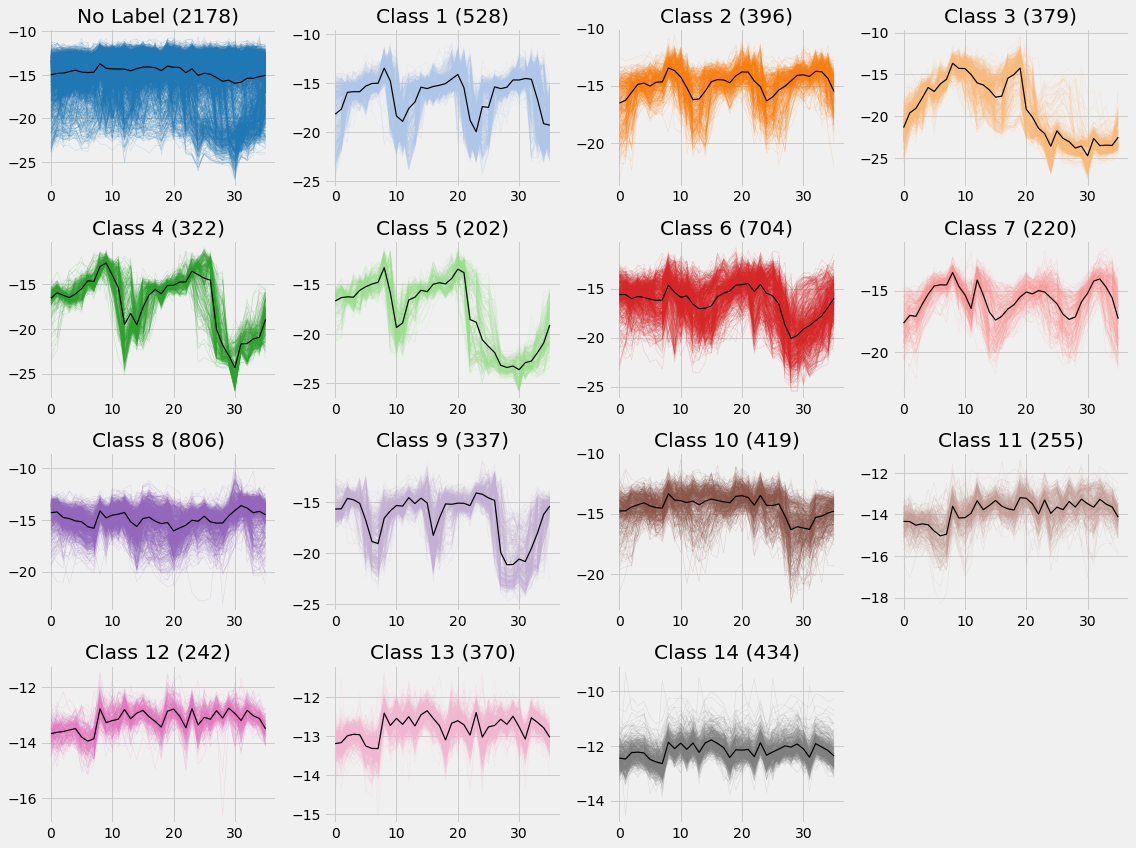

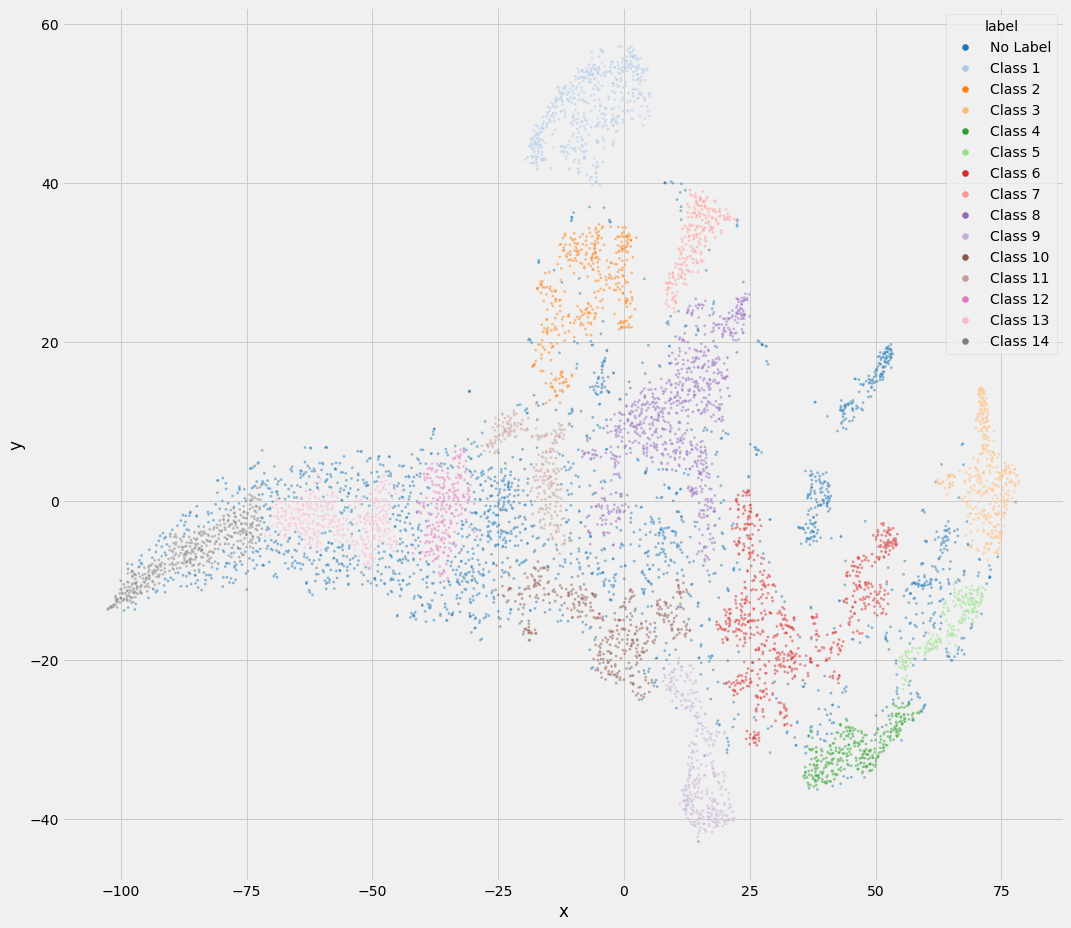

In [99]:
sns.scatterplot(data=df_pt, x='x', y='y', hue='label', alpha=0.5, s=8, palette=cmap)
plt.gcf().set_size_inches([16, 15])

plot_class_hys(df_ts)

# Save Label

In [98]:
df_lab = df_pt[['label']]
df_lab = df_lab.sort_index()
df_lab.columns = ['Label']
# df_lab['Label'] = [int(item.split(' ')[1]) for item in df_lab['Label']]
df_lab.index.name = 'PID'
df_lab.to_csv(data_folder + f'label_{normal_type}_{target_year}_hdbscan.csv')

# More Info on HDBSCAN

- only avaiable when use hdbscan.HDBSCAN, not sklearn.cluster.HDBSCAN

In [46]:
hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)
plt.gcf().set_size_inches([40, 36])

AttributeError: 'HDBSCAN' object has no attribute 'minimum_spanning_tree_'

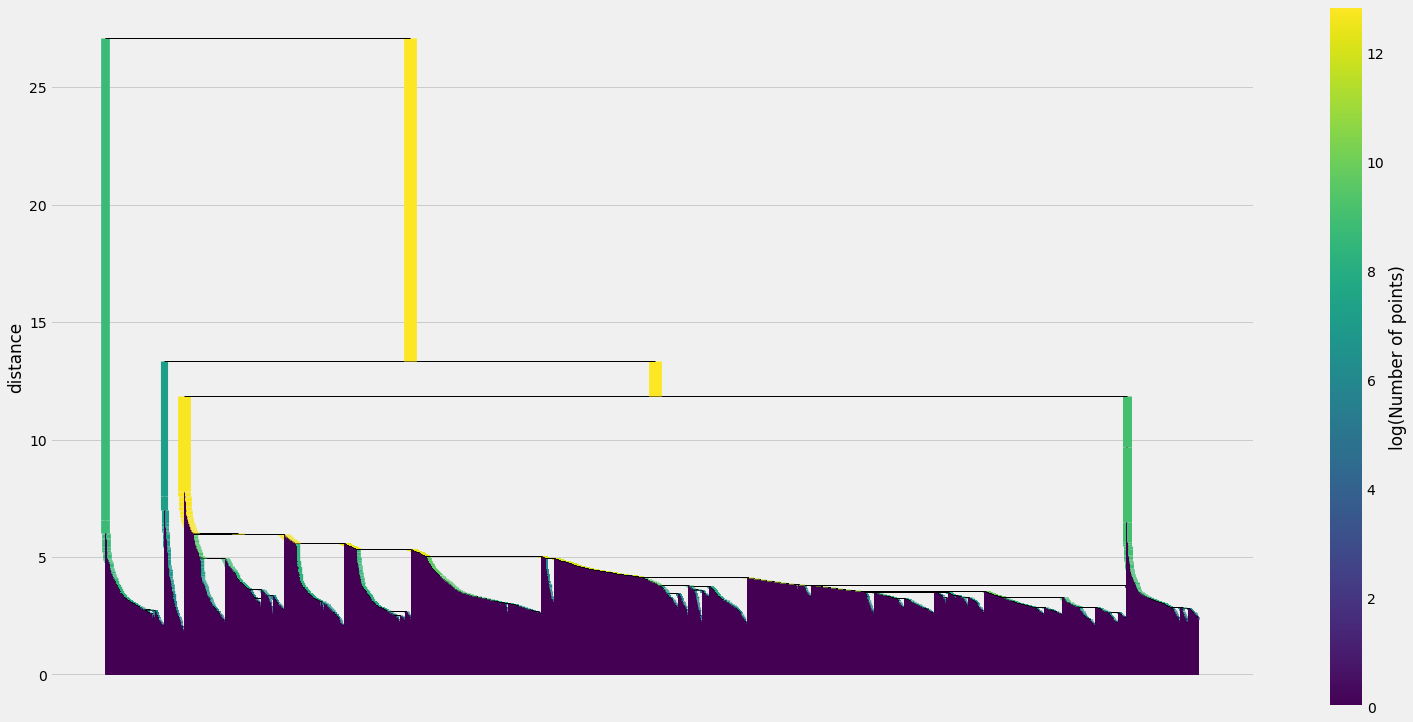

In [65]:
hdbscan.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.gcf().set_size_inches([24, 12])

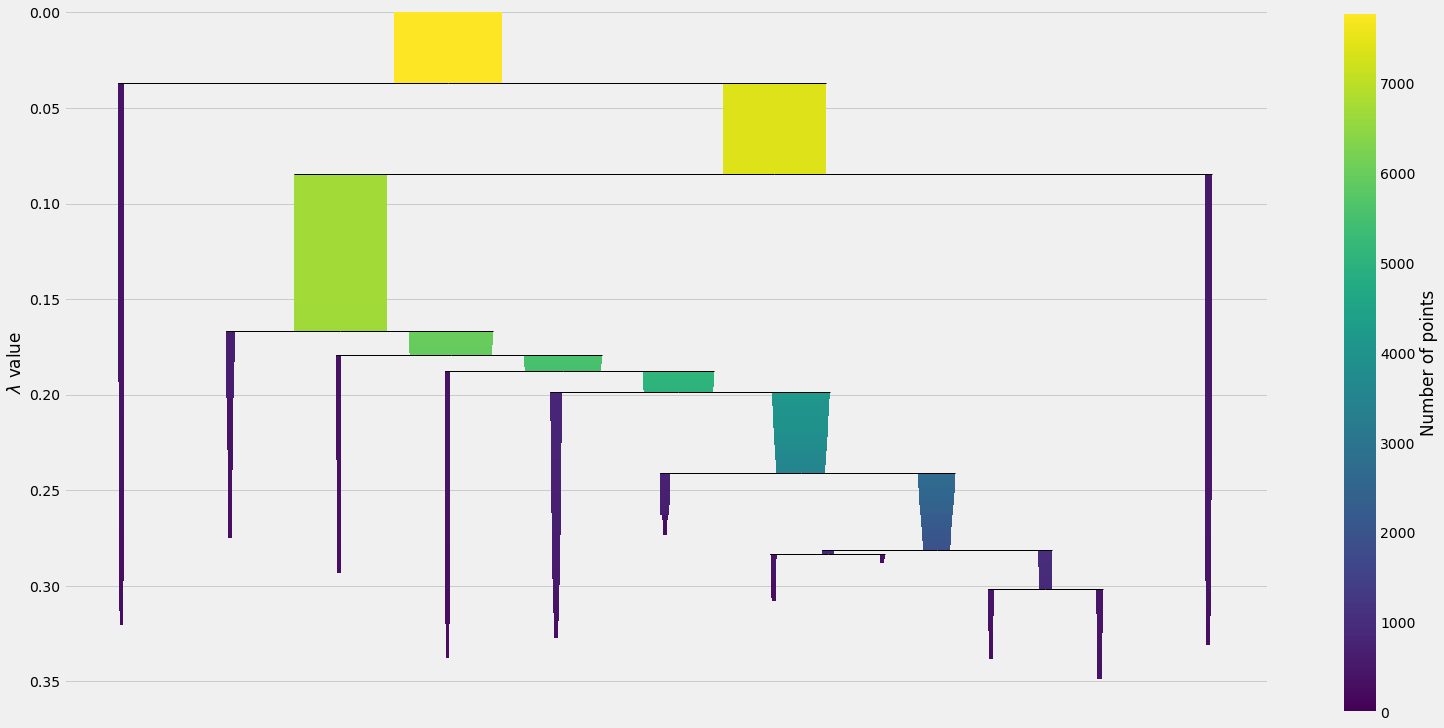

In [66]:
hdbscan.condensed_tree_.plot()
plt.gcf().set_size_inches([24, 12])